In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import simgraph.my_simgraph_06 as sg
import dataprocess.data_handler_03 as dh

# Test train and validation set construction

In [2]:
train_num = 10
val_num = 5

def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
               'spike_data': None, 'group_id': None, 'transform': None, 'ind_min': 0, 'ind_max': 13203, 'feature_id': 'mnist-sift'}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=1324)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('# of features = ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  10 , val_num =  5
# of features =  256
training data contains 5 points (50.00%) of label 1.
validation data contains 2 points (40.00%) of label 1.
train_smpls =  [ 2933  6491  7697  2120   549   841   987  9976 10586  5583] 
val_smpls =  [ 551 2938 2134 6626 1062]
train_lbls =  [ 1.  1.  1.  1.  1. -1. -1. -1. -1. -1.] 
val_lbls =  [ 1.  1. -1. -1. -1.]
train_des =  [[-0.06471857 -0.02183101 -0.01619479 ... -0.0546007  -0.03830477
  -0.02926758]
 [ 0.0979427  -0.01554806 -0.01153393 ... -0.03888665 -0.02728068
  -0.02084438]
 [-0.04958232 -0.01672522 -0.01240718 ... -0.0418308  -0.02934613
  -0.01603489]
 ...
 [ 0.0232997  -0.01397355 -0.01036593 ... -0.03494872 -0.02451805
  -0.01873353]
 [ 0.04722935 -0.00932618 -0.00691839 ... -0.02332535 -0.01636375
  -0.01250307]
 [ 0.0397879  -0.00961576 -0.00713321 ... -0.0240496  -0.01687184
  -0.01289129]] 
val_des =  [[ 0.19883202 -0.01034166 -0.01388549 ... -0.04109289 -0.0328427
  -0.02509416]
 [ 0.04122896 -0.01804326 -0.01338

# Load an exmplary MNIST image

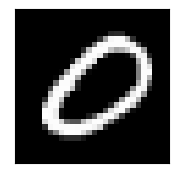

In [3]:
ind = 102
# load image
org_path = '../../data/fe_exp/mnist-org/'
image = np.loadtxt(org_path+'fv_'+str(ind)+'.txt')

# show image
def display_image(image, title=None):
    img_sz = (28,28)
    plt.figure(figsize=(2,2))
    plt.imshow(image, cmap='gray')
    _=plt.xticks([])
    _=plt.yticks([])
    if title is not None:
        plt.title(title)
        
img_sz = (28,28)
display_image(image.reshape(img_sz))

# Find SIFT keypoints

In [4]:
data_sz = 1
data_x = image.reshape((1, -1))
data_y = np.array([0]) # the labels

In [5]:
# convert train and validation images from 1D to 2D with 3 channels of [0,255] pixel values
data_x_sift = ((data_x.reshape((data_x.shape[0], img_sz[0], img_sz[1], 1)))*256).astype('uint8')
data_x_sift = np.broadcast_to(data_x_sift, (data_x.shape[0], img_sz[0], img_sz[1], 3))

In [6]:
# SIFT default parameter values are:
nfeatures = 0
nOctaveLayers = 3
contrastThreshold = 0.04
edgeThreshold = 10
sigma = 1.6

sift = cv.SIFT_create(nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, sigma)

# extract SIFT descriptors for all training and validation images
gray = np.array([cv.cvtColor(data_x_sift[0],cv.COLOR_BGR2GRAY)])
for i in range(1, data_x_sift.shape[0]):
    gray = np.append(gray, [cv.cvtColor(data_x_sift[i],cv.COLOR_BGR2GRAY)], axis=0)
kp = []
des = []
for i in range(gray.shape[0]):
    _kp, _des = sift.detectAndCompute(gray[i],None)
    kp.append(_kp)
    des.append(_des)

In [7]:
# discard all images that have less than 2 keypoints
num_keypoints = [len(kp[i]) for i in range(len(kp))]
to_discard_ind = [i for i in range(len(num_keypoints)) if (num_keypoints[i]==0 or num_keypoints[i]==1)]
x_sift_mod = np.delete(data_x_sift, to_discard_ind, axis=0)
y_mod = np.delete(data_y, to_discard_ind, axis=0)
gray_mod = np.delete(gray, to_discard_ind, axis=0)
kp_mod = [kp[i] for i in range(len(kp)) if i not in to_discard_ind]
des_mod = [des[i] for i in range(len(des)) if i not in to_discard_ind]

# find new number of train & val images
data_sz_mod = data_sz - len(to_discard_ind)
print('{} image(s) have at least two keypoints.'.format(data_sz_mod))

1 image(s) have at least two keypoints.


In [8]:
# select only two keypoints in all images with more than 2 keypoints
for i in range(len(kp_mod)): # for each training or validation image
    # calculate keypoint's distance from the top-left and bottom-right corners
    left_dists = [(kp_mod[i][j], np.sum(np.array(kp_mod[i][j].pt)**2), des_mod[i][j]) for j in range(len(kp_mod[i]))]
    right_dists = [(kp_mod[i][j], np.sum(np.array([img_sz[0]-kp_mod[i][j].pt[0], img_sz[1]-kp_mod[i][j].pt[1]])**2), \
                    des_mod[i][j]) for j in range(len(kp_mod[i]))]

    # select closest keypoints to the top-left and bottom-right corners, discard all other keypoints
    kp_mod[i] = (min(left_dists, key=lambda x:x[1])[0], min(right_dists, key=lambda x:x[1])[0])
    des_mod[i] = np.array([min(left_dists, key=lambda x:x[1])[2], min(right_dists, key=lambda x:x[1])[2]])

    # concatenate two descriptors
    des_mod[i] = des_mod[i].reshape(-1)
des_mod = np.array(des_mod)

print('Only two keypoints are kept.\nkp_mod[0]: ', kp_mod[0], '\ndes_mod.shape: ', des_mod.shape)

Only two keypoints are kept.
kp_mod[0]:  (< cv2.KeyPoint 0x7f279dc6aa20>, < cv2.KeyPoint 0x7f279dc6a720>) 
des_mod.shape:  (1, 256)


In [9]:
# Normalize descriptors by method 2: double normalization
# step 1 - feature-wise: subtract mean and divide by standard deviation of each feature.
des_mod_nrm = des_mod.copy()
des_mod_mean = np.mean(des_mod_nrm, axis=0, keepdims=True)
des_mod_std = np.std(des_mod_nrm, axis=0, keepdims=True)
des_mod_nrm = des_mod_nrm - des_mod_mean
des_mod_nrm = des_mod_nrm / (des_mod_std + 0.01)
# step 2 - smaple-wise: normalize l2-norm of each vector to 1.
des_mod_norm = np.linalg.norm(des_mod_nrm, axis=1, keepdims=True)
des_mod_nrm = des_mod_nrm / (des_mod_norm + 0.01)

print('Final results are stored in kp_mod and des_mod_nrm.')

Final results are stored in kp_mod and des_mod_nrm.


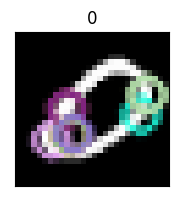

In [10]:
# draw all extracted keypoints
img_kp_raw = cv.drawKeypoints(gray[0],kp[0],0)
display_image(img_kp_raw, data_y[0])

The first keypoint in the feature vectors is the closest to the top-left corner, and the second keyponit is closest to the bottom-right.


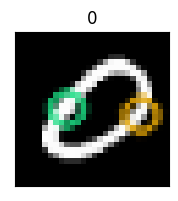

In [11]:
# draw only the two selected keypoits
img_kp = cv.drawKeypoints(gray_mod[0],kp_mod[0],0)
display_image(img_kp, data_y[0])
print('The first keypoint in the feature vectors is the closest to the top-left corner, and the second keyponit is closest to the bottom-right.')

# Visualize an optimized metric matrix

In [12]:
# load a singl metric matrix
model_path = '../../data/experiments/comparison/2023_07_23-fact-lgrg-mnistsift/fact/'
M = np.load(model_path+'matrices/finalM_50_50_4.npy')

In [13]:
# # take an average of many metric matrices
# model_path = '../../data/experiments/comparison/2023_07_23-fact-lgrg-mnistsift/fact/'
# num_matrices = 100
# M = np.zeros((256, 256))
# for i in range(num_matrices):
#     M += np.load(model_path+'matrices/finalM_50_50_'+str(i)+'.npy')
# M = M / num_matrices

Large entries x:  [153 153 105 131 153 154 153] 
Large entries y:  [105 131 153 153 153 153 154]
Large diagonal entries:  [153]


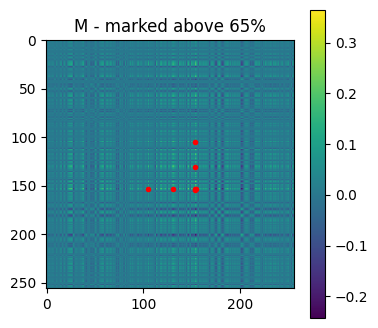

In [38]:
def visualize_M(M, large_x, large_y, mark_th, marker_color='r', save_name=None):
    plt.figure(figsize=(4,4))
    plt.imshow(M)
    plt.colorbar()        
    plt.plot(large_x, large_y, marker='o', markersize=3, color=marker_color, linestyle='')
    plt.title('M - marked above {}%'.format(mark_th))
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    plt.close()

# parameters to visualize the optimized M
f_sz = 256 # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
mark_th = 65

# find large entries
lim = (mark_th/100) * np.max(M)
large_x = xloc[M > lim]
large_y = yloc[M > lim]
# sort based on the M entry
large_x_sorted = np.array([x[0] for x in sorted(list(zip(large_x, M[M > lim])), key=lambda x: x[1], reverse=True)])
large_y_sorted = np.array([x[0] for x in sorted(list(zip(large_y, M[M > lim])), key=lambda x: x[1], reverse=True)])
#show results
print('Large entries x: ', large_x, '\nLarge entries y: ', large_y)
large_diag_sorted = large_x_sorted[large_x_sorted == large_y_sorted]
print('Large diagonal entries: ', large_diag_sorted)

# display the metric matrix
visualize_M(M, large_x_sorted, large_y_sorted, mark_th, marker_color='r', save_name=model_path+'Mtest.png')

# Visualize diagonal elements of the metric matrix

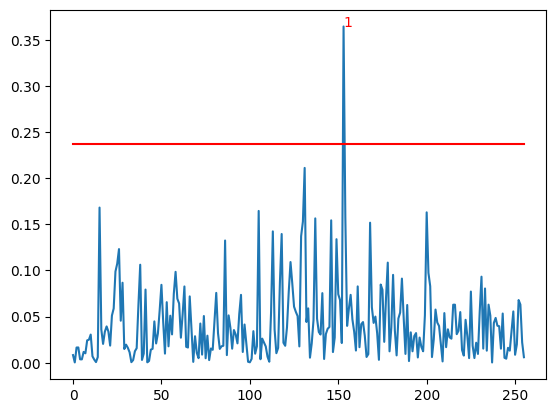

In [39]:
Mdiag = np.diagonal(M)

plt.figure()
plt.plot(np.arange(f_sz), Mdiag)
plt.plot(np.arange(f_sz), lim*np.ones(f_sz), color='r')
i = 1
for ind in large_diag_sorted:
    # plt.text(ind, M[ind, ind], '({}, {:.2f})'.format(ind, M[ind, ind]), color='r')
    plt.text(ind, M[ind, ind], str(i), color='r')
    i += 1
plt.savefig(model_path+'Mdiag.png')
plt.show()

In [40]:
# compute average contribution scores for the keypoints
left_kp_avg = np.median(Mdiag[:128])
right_kp_avg = np.median(Mdiag[128:])
diff_per = (max(left_kp_avg, right_kp_avg) - min(left_kp_avg, right_kp_avg))/max(left_kp_avg, right_kp_avg)
print('Left kp average score: ', left_kp_avg, '\nRight kp average score: ', right_kp_avg)
print('Percentage of difference between the two scores: ', diff_per)

Left kp average score:  0.024580066058379563 
Right kp average score:  0.037332522526241564
Percentage of difference between the two scores:  0.3415910740801969


In [41]:
# get the meaning of each feature vector entry
left_or_right_kp = large_diag_sorted//128
quad1 = large_diag_sorted%128//8//4
quad2 = large_diag_sorted%128//8%4
orient = large_diag_sorted%128%8
arrow_color = ['red'] * len(large_diag_sorted)

print('Large diagonal elements meaning in SIFT features:\nleft kp (0) or right kp (1):\t', left_or_right_kp)
print('which major quadrant (0,1,2,3):\t', quad1)
print('which minor quadrant (0,1,2,3):\t', quad2)
print('which orientation (0,1,2,..,7):\t', orient)
print('arrow colors:\t', arrow_color)

Large diagonal elements meaning in SIFT features:
left kp (0) or right kp (1):	 [1]
which major quadrant (0,1,2,3):	 [0]
which minor quadrant (0,1,2,3):	 [3]
which orientation (0,1,2,..,7):	 [1]
arrow colors:	 ['red']


In [42]:
def draw_orientations(kploc, quad_center, quad_num, Mdiag, base_length, colors, texts=None, fsize=15, bias=0.05):
    indices = np.arange(256)
    ranj = quad_num[0]*32+quad_num[1]*8
    if kploc == 'bottom-right':
        ranj += 128
    elif kploc != 'top-left':
        print('kploc variable not correct.')
        return
    
    indices = indices[(indices >= ranj) & (indices < 8+ranj)]
    quad_mags = Mdiag[indices]
    PHI = base_length*1/np.sqrt(2)
    
    arrow_directions = [(quad_mags[0]*base_length, 0),(quad_mags[1]*PHI, quad_mags[1]*PHI),
                        (0, quad_mags[2]*base_length),(-quad_mags[3]*PHI, quad_mags[3]*PHI),
                       (-quad_mags[4]*base_length, 0),(-quad_mags[5]*PHI, -quad_mags[5]*PHI),
                        (0, -quad_mags[6]*base_length),(quad_mags[7]*PHI, -quad_mags[7]*PHI)]
    
    for i in range(8):
        plt.arrow(quad_center[0], quad_center[1], arrow_directions[i][0], arrow_directions[i][1], width=0.0001, head_width=0.05, edgecolor=colors[i], facecolor=colors[i])
        plt.annotate(texts[i], (bias+quad_center[0]+arrow_directions[i][0], bias+quad_center[1]+arrow_directions[i][1]), fontsize=fsize, color=colors[i])

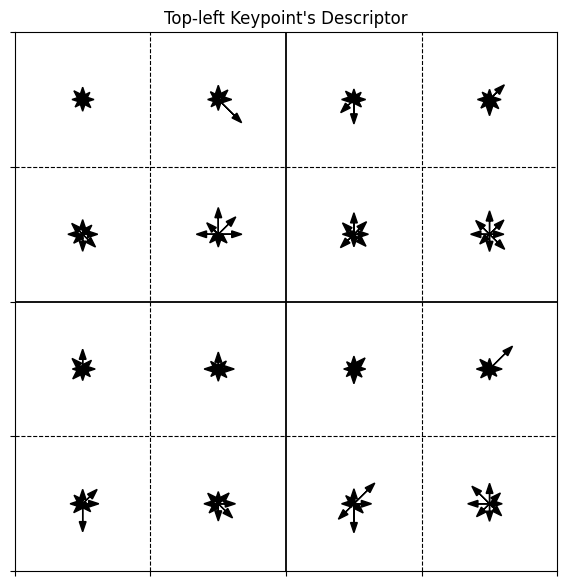

In [43]:
# visualize all M diagonal entries
plt.figure(figsize=(7,7))
plt.xticks([0,1,2,3,4], [])
plt.yticks([0,1,2,3,4], [])
plt.xlim([0,4])
plt.ylim([0,4])
plt.title('Top-left Keypoint\'s Descriptor')
# draw major quadrant lines
plt.axhline(y=2, xmin=0, xmax=4, linestyle='-', linewidth=1.3, color='black')
plt.axvline(x=2, ymin=0, ymax=4, linestyle='-', linewidth=1.3, color='black')
# draw minor quadrant lines
plt.axhline(y=1, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axhline(y=3, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=1, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=3, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
# draw orientation arrows
quad_nums = [(0, 0),(0, 1),(0, 2),(0, 3),
            (1, 0),(1, 1),(1, 2),(1, 3),
            (2, 0),(2, 1),(2, 2),(2, 3),
            (3, 0),(3, 1),(3, 2),(3, 3)]

quad_centers = [(0.5,3.5), (1.5,3.5), (0.5,2.5), (1.5,2.5),
               (2.5,3.5), (3.5,3.5), (2.5,2.5), (3.5,2.5),
               (0.5,1.5), (1.5,1.5), (0.5,0.5), (1.5,0.5),
               (2.5,1.5), (3.5,1.5), (2.5,0.5), (3.5,0.5)]

# base_lengths = [20, 3, 6, 3,
#                3, 6, 4, 3,
#                5, 6, 3, 5,
#                10, 3, 3, 4]

base_lengths = [1] * 16

for i in range(16):
    # set parameters
    quad_num = quad_nums[i]
    quad_center = quad_centers[i]
    base_length = base_lengths[i]
    # set the arrow colors
    colors = ['black'] * 8
    texts = [''] * 8
    for j in range(len(large_diag_sorted)):
        if (left_or_right_kp[j] == 0) and (quad_num == (quad1[j], quad2[j])):
            colors[orient[j]] = arrow_color[j]
            texts[orient[j]]  = str(j+1)
    # draw
    draw_orientations('top-left', quad_center, quad_num, Mdiag, base_length, colors, texts, fsize=15)
    
plt.savefig(model_path+'top-left-desc.png')

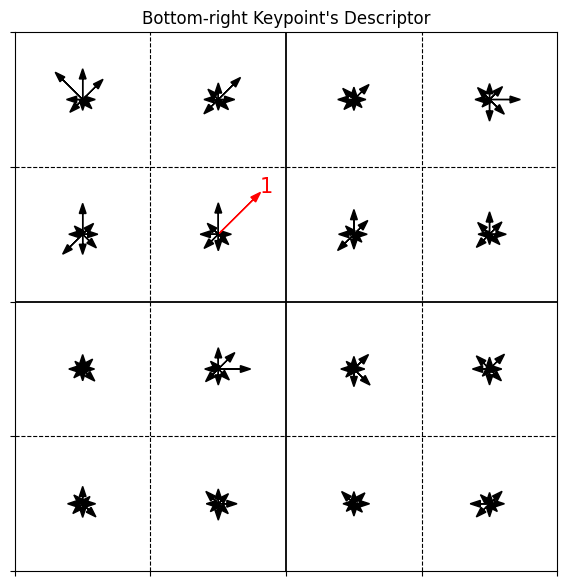

In [44]:
# visualize all M diagonal entries
plt.figure(figsize=(7,7))
plt.xticks([0,1,2,3,4], [])
plt.yticks([0,1,2,3,4], [])
plt.xlim([0,4])
plt.ylim([0,4])
plt.title('Bottom-right Keypoint\'s Descriptor')
# draw major quadrant lines
plt.axhline(y=2, xmin=0, xmax=4, linestyle='-', linewidth=1.3, color='black')
plt.axvline(x=2, ymin=0, ymax=4, linestyle='-', linewidth=1.3, color='black')
# draw minor quadrant lines
plt.axhline(y=1, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axhline(y=3, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=1, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=3, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
# draw orientation arrows
quad_nums = [(0, 0),(0, 1),(0, 2),(0, 3),
            (1, 0),(1, 1),(1, 2),(1, 3),
            (2, 0),(2, 1),(2, 2),(2, 3),
            (3, 0),(3, 1),(3, 2),(3, 3)]

quad_centers = [(0.5,3.5), (1.5,3.5), (0.5,2.5), (1.5,2.5),
               (2.5,3.5), (3.5,3.5), (2.5,2.5), (3.5,2.5),
               (0.5,1.5), (1.5,1.5), (0.5,0.5), (1.5,0.5),
               (2.5,1.5), (3.5,1.5), (2.5,0.5), (3.5,0.5)]

# base_lengths = [2.5, 3, 2.5, 1.5,
#                5, 2, 3, 3,
#                8, 2, 7, 6,
#                5, 6, 8, 5]

base_lengths = [1] * 16

for i in range(16):
    # set parameters
    quad_num = quad_nums[i]
    quad_center = quad_centers[i]
    base_length = base_lengths[i]
    # set the arrow colors
    colors = ['black'] * 8
    texts = [''] * 8
    for j in range(len(large_diag_sorted)):
        if (left_or_right_kp[j] == 1) and (quad_num == (quad1[j], quad2[j])):
            colors[orient[j]] = arrow_color[j]
            texts[orient[j]]  = str(j+1)
    # draw
    draw_orientations('bottom-right', quad_center, quad_num, Mdiag, base_length, colors, texts, fsize=15)
    
plt.savefig(model_path+'bottom-right-desc.png')

# Non-diagonal elements

In [45]:
large_x_nd_sorted = large_x_sorted[large_y_sorted != large_x_sorted]
large_y_nd_sorted = large_y_sorted[large_y_sorted != large_x_sorted]
large_nd_sorted = list(zip(large_x_nd_sorted, large_y_nd_sorted))
print('Largest non-diagonal elements:\n', large_nd_sorted)

Largest non-diagonal elements:
 [(153, 131), (131, 153), (153, 105), (105, 153), (154, 153), (153, 154)]


In [46]:
for pair in large_nd_sorted:
    if (pair[1], pair[0]) in large_nd_sorted:
        large_nd_sorted.remove(pair)

In [47]:
large_nd_sorted = np.array(large_nd_sorted)
# large_nd_sorted = large_nd_sorted[0:1,:]
left_or_right_kp_nd = large_nd_sorted//128
quad1_nd = large_nd_sorted%128//8//4
quad2_nd = large_nd_sorted%128//8%4
orient_nd = large_nd_sorted%128%8

In [48]:
print(large_nd_sorted)

[[131 153]
 [105 153]
 [153 154]]


In [49]:
color_pallete = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink', 'gray', 'olive', 'cyan']
arrow_color_nd = []
for i in range(len(large_nd_sorted)):
    arrow_color_nd.append(color_pallete[i%len(color_pallete)])

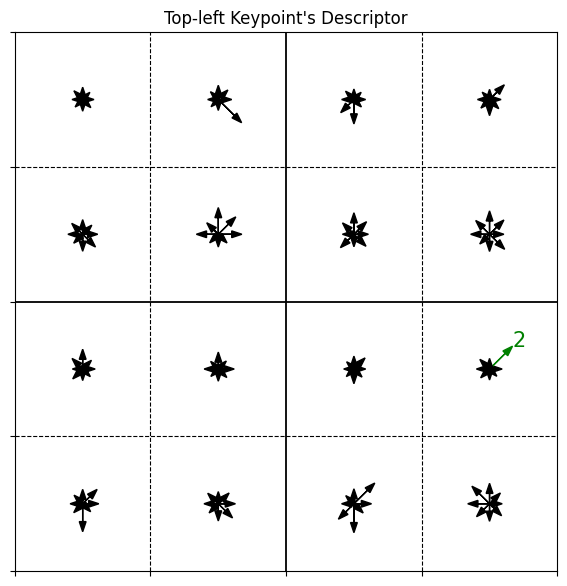

In [50]:
# visualize all M diagonal entries
plt.figure(figsize=(7,7))
plt.xticks([0,1,2,3,4], [])
plt.yticks([0,1,2,3,4], [])
plt.xlim([0,4])
plt.ylim([0,4])
plt.title('Top-left Keypoint\'s Descriptor')
# draw major quadrant lines
plt.axhline(y=2, xmin=0, xmax=4, linestyle='-', linewidth=1.3, color='black')
plt.axvline(x=2, ymin=0, ymax=4, linestyle='-', linewidth=1.3, color='black')
# draw minor quadrant lines
plt.axhline(y=1, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axhline(y=3, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=1, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=3, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
# draw orientation arrows
quad_nums = [(0, 0),(0, 1),(0, 2),(0, 3),
            (1, 0),(1, 1),(1, 2),(1, 3),
            (2, 0),(2, 1),(2, 2),(2, 3),
            (3, 0),(3, 1),(3, 2),(3, 3)]

quad_centers = [(0.5,3.5), (1.5,3.5), (0.5,2.5), (1.5,2.5),
               (2.5,3.5), (3.5,3.5), (2.5,2.5), (3.5,2.5),
               (0.5,1.5), (1.5,1.5), (0.5,0.5), (1.5,0.5),
               (2.5,1.5), (3.5,1.5), (2.5,0.5), (3.5,0.5)]

# base_lengths = [20, 3, 6, 3,
#                3, 6, 4, 3,
#                5, 6, 3, 5,
#                10, 3, 3, 4]

base_lengths = [1] * 16

for i in range(16):
    # set parameters
    quad_num = quad_nums[i]
    quad_center = quad_centers[i]
    base_length = base_lengths[i]
    # set the arrow colors
    colors = ['black'] * 8
    texts  = [''] * 8
    for j in range(len(large_nd_sorted)):
        if (left_or_right_kp_nd[j,0] == 0) and (quad_num == (quad1_nd[j,0], quad2_nd[j,0])):
            colors[orient_nd[j,0]] = arrow_color_nd[j]
            texts[orient_nd[j,0]]  = str(j+1)
        if (left_or_right_kp_nd[j,1] == 0) and (quad_num == (quad1_nd[j,1], quad2_nd[j,1])):
            colors[orient_nd[j,1]] = arrow_color_nd[j]
            texts[orient_nd[j,1]]  = str(j+1)
    # draw
    draw_orientations('top-left', quad_center, quad_num, Mdiag, base_length, colors, texts, fsize=15)
    
plt.savefig(model_path+'top-left-desc-non-diag.png')

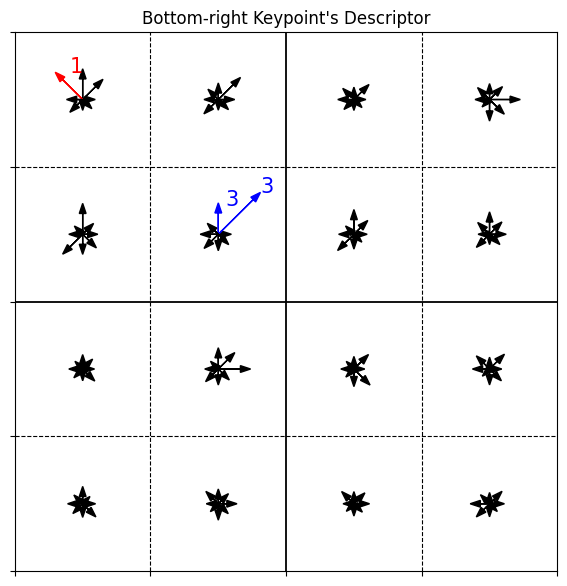

In [51]:
# visualize all M diagonal entries
plt.figure(figsize=(7,7))
plt.xticks([0,1,2,3,4], [])
plt.yticks([0,1,2,3,4], [])
plt.xlim([0,4])
plt.ylim([0,4])
plt.title('Bottom-right Keypoint\'s Descriptor')
# draw major quadrant lines
plt.axhline(y=2, xmin=0, xmax=4, linestyle='-', linewidth=1.3, color='black')
plt.axvline(x=2, ymin=0, ymax=4, linestyle='-', linewidth=1.3, color='black')
# draw minor quadrant lines
plt.axhline(y=1, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axhline(y=3, xmin=0, xmax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=1, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
plt.axvline(x=3, ymin=0, ymax=4, linestyle='--', linewidth=0.8, color='black')
# draw orientation arrows
quad_nums = [(0, 0),(0, 1),(0, 2),(0, 3),
            (1, 0),(1, 1),(1, 2),(1, 3),
            (2, 0),(2, 1),(2, 2),(2, 3),
            (3, 0),(3, 1),(3, 2),(3, 3)]

quad_centers = [(0.5,3.5), (1.5,3.5), (0.5,2.5), (1.5,2.5),
               (2.5,3.5), (3.5,3.5), (2.5,2.5), (3.5,2.5),
               (0.5,1.5), (1.5,1.5), (0.5,0.5), (1.5,0.5),
               (2.5,1.5), (3.5,1.5), (2.5,0.5), (3.5,0.5)]

# base_lengths = [2.5, 3, 2.5, 1.5,
#                5, 2, 3, 3,
#                8, 2, 7, 6,
#                5, 6, 8, 5]

base_lengths = [1] * 16

for i in range(16):
    # set parameters
    quad_num = quad_nums[i]
    quad_center = quad_centers[i]
    base_length = base_lengths[i]
    # set the arrow colors
    colors = ['black'] * 8
    texts  = [''] * 8
    for j in range(len(large_nd_sorted)):
        if (left_or_right_kp_nd[j,0] == 1) and (quad_num == (quad1_nd[j,0], quad2_nd[j,0])):
            colors[orient_nd[j,0]] = arrow_color_nd[j]
            texts[orient_nd[j,0]]  = str(j+1)
        if (left_or_right_kp_nd[j,1] == 1) and (quad_num == (quad1_nd[j,1], quad2_nd[j,1])):
            colors[orient_nd[j,1]] = arrow_color_nd[j]
            texts[orient_nd[j,1]]  = str(j+1)
    # draw
    draw_orientations('bottom-right', quad_center, quad_num, Mdiag, base_length, colors, texts, fsize=15)
    
plt.savefig(model_path+'bottom-right-desc-non-diag.png')